In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
from astropy.visualization import make_lupton_rgb

from hydra import initialize, compose
from hydra.utils import instantiate
from bliss.surveys.dc2 import split_tensor, unpack_dict
from case_studies.weak_lensing.utils.weighted_avg_ellip import compute_weighted_avg_ellip

with initialize(config_path="../../", version_base = None):
    cfg = compose("config_dc2_redbin3")

**Load image and catalog**

In [2]:
dc2 = instantiate(cfg.surveys.dc2)
dc2._load_image_and_bg_files_list()

98

In [3]:
# this cell takes 10-20 seconds
image_index = 1
result_dict = dc2.load_image_and_catalog(image_index)

image = result_dict["inputs"]["image"]
tile_dict = result_dict["tile_dict"]
psf_params = result_dict["inputs"]["psf_params"]

shear1 = tile_dict["shear1_sum"] / (
    tile_dict["shear1_count"]
    + (tile_dict["shear1_count"] == 0) * torch.ones_like(tile_dict["shear1_count"])
)
shear2 = tile_dict["shear2_sum"] / (
    tile_dict["shear2_count"]
    + (tile_dict["shear2_count"] == 0) * torch.ones_like(tile_dict["shear2_count"])
)
convergence = tile_dict["convergence_sum"] / (
    tile_dict["convergence_count"]
    + (tile_dict["convergence_count"] == 0)
    * torch.ones_like(tile_dict["convergence_count"])
)
ellip1_lensed = tile_dict["ellip1_lensed_sum"] / (
    tile_dict["ellip1_lensed_count"]
    + (tile_dict["ellip1_lensed_count"] == 0)
    * torch.ones_like(tile_dict["ellip1_lensed_count"])
)
ellip2_lensed = tile_dict["ellip2_lensed_sum"] / (
    tile_dict["ellip2_lensed_count"]
    + (tile_dict["ellip2_lensed_count"] == 0)
    * torch.ones_like(tile_dict["ellip2_lensed_count"])
)
ellip_lensed = torch.stack((ellip1_lensed.squeeze(-1), ellip2_lensed.squeeze(-1)), dim=-1)
ellip1_lsst = tile_dict["ellip1_lsst_sum"] / (
    tile_dict["ellip1_lsst_count"]
    + (tile_dict["ellip1_lsst_count"] == 0)
    * torch.ones_like(tile_dict["ellip1_lsst_count"])
)
ellip2_lsst = tile_dict["ellip2_lsst_sum"] / (
    tile_dict["ellip2_lsst_count"]
    + (tile_dict["ellip2_lsst_count"] == 0)
    * torch.ones_like(tile_dict["ellip2_lsst_count"])
)
ellip_lsst = torch.stack((ellip1_lsst.squeeze(-1), ellip2_lsst.squeeze(-1)), dim=-1)
redshift = tile_dict["redshift_sum"] / (
    tile_dict["redshift_count"]
    + (tile_dict["redshift_count"] == 0) * torch.ones_like(tile_dict["redshift_count"])
)
ra = tile_dict["ra_sum"] / (
    tile_dict["ra_count"]
    + (tile_dict["ra_count"] == 0) * torch.ones_like(tile_dict["ra_count"])
)
dec = tile_dict["dec_sum"] / (
    tile_dict["dec_count"]
    + (tile_dict["dec_count"] == 0) * torch.ones_like(tile_dict["dec_count"])
)

tile_dict["shear_1"] = shear1
tile_dict["shear_2"] = shear2
tile_dict["convergence"] = convergence
tile_dict["ellip_lensed"] = ellip_lensed
tile_dict["ellip_lsst"] = ellip_lsst
tile_dict["ellip_lsst_wavg"] = compute_weighted_avg_ellip(
    tile_dict, dc2.avg_ellip_kernel_size, dc2.avg_ellip_kernel_sigma
)
tile_dict["redshift"] = redshift
tile_dict["ra"] = ra
tile_dict["dec"] = dec

data_splits = dc2.split_image_and_tile_cat(image, tile_dict, tile_dict.keys(), psf_params)

data_to_cache = unpack_dict(data_splits)

/home/twhit/bliss/bliss/surveys/dc2.py:418: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  torch.tensor(psf_params_cur_band)


**Image**

In [4]:
image = data_to_cache[0]['images']

In [5]:
def create_rgb(image, bgr=[1, 2, 3], stretch=1, Q=8, scale=[0.35, 0.45, 0.6]):
    if scale is None:
        r_im = image[bgr[2]]
        g_im = image[bgr[1]]
        b_im = image[bgr[0]]
    else:
        # manually re-scaling the images here
        r_im = image[bgr[2]] * scale[0]
        g_im = image[bgr[1]] * scale[1]
        b_im = image[bgr[0]] * scale[2]

    rgb = make_lupton_rgb(image_r=r_im,
                          image_g=g_im,
                          image_b=b_im,
                          stretch=stretch, Q=Q)

    return rgb

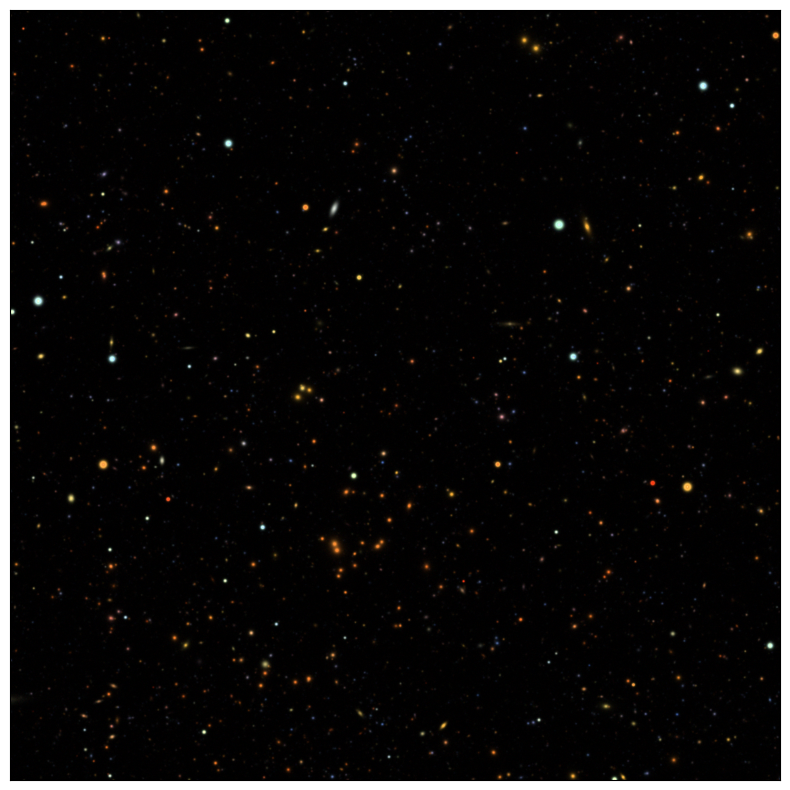

In [6]:
fig, ax = plt.subplots(1, 1, figsize = (8,8))
_ = ax.imshow(create_rgb(image, stretch=1, Q=4, scale=[0.35, 0.45, 0.6]), origin = 'lower')
_ = ax.set_xticks([])
_ = ax.set_yticks([])

fig.tight_layout()

fig.savefig("figures/dc2image.png", dpi = 300, transparent = True, bbox_inches = 'tight', pad_inches = 0)

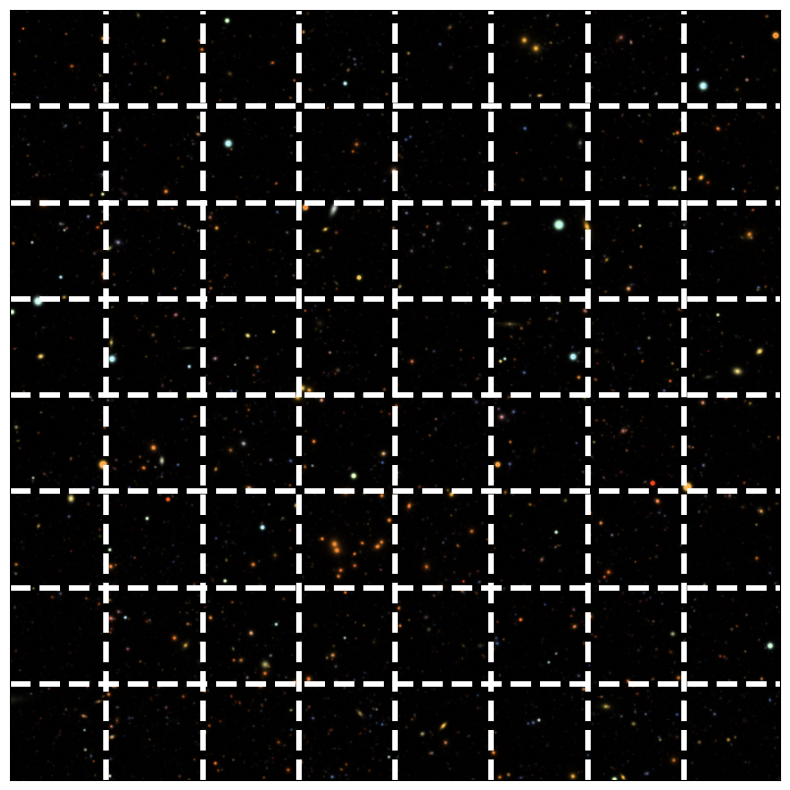

In [7]:
fig, ax = plt.subplots(1, 1, figsize = (8,8))
_ = ax.imshow(create_rgb(image, stretch=1, Q=4, scale=[0.35, 0.45, 0.6]), origin = 'lower')
_ = ax.set_xticks([])
_ = ax.set_yticks([])
_ = ax.vlines(x = [256 * c for c in range(1, 2048//256)],
              ymin = 0, ymax = 2048, color = 'white', linestyle='dashed', linewidth = 4)
_ = ax.hlines(y = [256 * c for c in range(1, 2048//256)],
              xmin = 0, xmax = 2048, color = 'white', linestyle='dashed', linewidth = 4)
_ = ax.set_xlim(0, 2048)
_ = ax.set_ylim(0, 2048)

fig.tight_layout()

fig.savefig("figures/dc2image_grid.png", dpi = 300, transparent = True, bbox_inches = 'tight', pad_inches = 0)

**Catalog**

In [8]:
shear1 = data_to_cache[0]['tile_catalog']['shear_1'].squeeze().flip(dims=[0,1])
shear2 = data_to_cache[0]['tile_catalog']['shear_2'].squeeze().flip(dims=[0,1])
convergence = data_to_cache[0]['tile_catalog']['convergence'].squeeze().flip(dims=[0,1])

In [9]:
galaxy_shear1 = torch.zeros_like(result_dict['other_info']['full_cat']['shear1'].squeeze())
galaxy_shear2 = torch.zeros_like(result_dict['other_info']['full_cat']['shear2'].squeeze())
galaxy_convergence = torch.zeros_like(result_dict['other_info']['full_cat']['convergence'].squeeze())
galaxy_plocs = torch.zeros_like(result_dict['other_info']['full_cat']['plocs_binned'].squeeze())

In [10]:
plocs_mask = (result_dict['other_info']['full_cat']['plocs_binned'].squeeze() <= 2048).all(dim=1)
plocs_mask *= (result_dict['other_info']['full_cat']['plocs_binned'].squeeze() != 0).all(dim=1)

In [11]:
for b in range(galaxy_plocs.shape[-1]):
    num = plocs_mask[:,b].sum()
    galaxy_shear1[:num,b] = result_dict['other_info']['full_cat']['shear1'].squeeze()[:,b][plocs_mask[:,b]]
    galaxy_shear2[:num,b] = result_dict['other_info']['full_cat']['shear2'].squeeze()[:,b][plocs_mask[:,b]]
    galaxy_convergence[:num,b] = result_dict['other_info']['full_cat']['convergence'].squeeze()[:,b][plocs_mask[:,b]]
    galaxy_plocs[:num,:,b] = result_dict['other_info']['full_cat']['plocs_binned'].squeeze()[:,:,b][plocs_mask[:,b]]

Redshift bin 0:

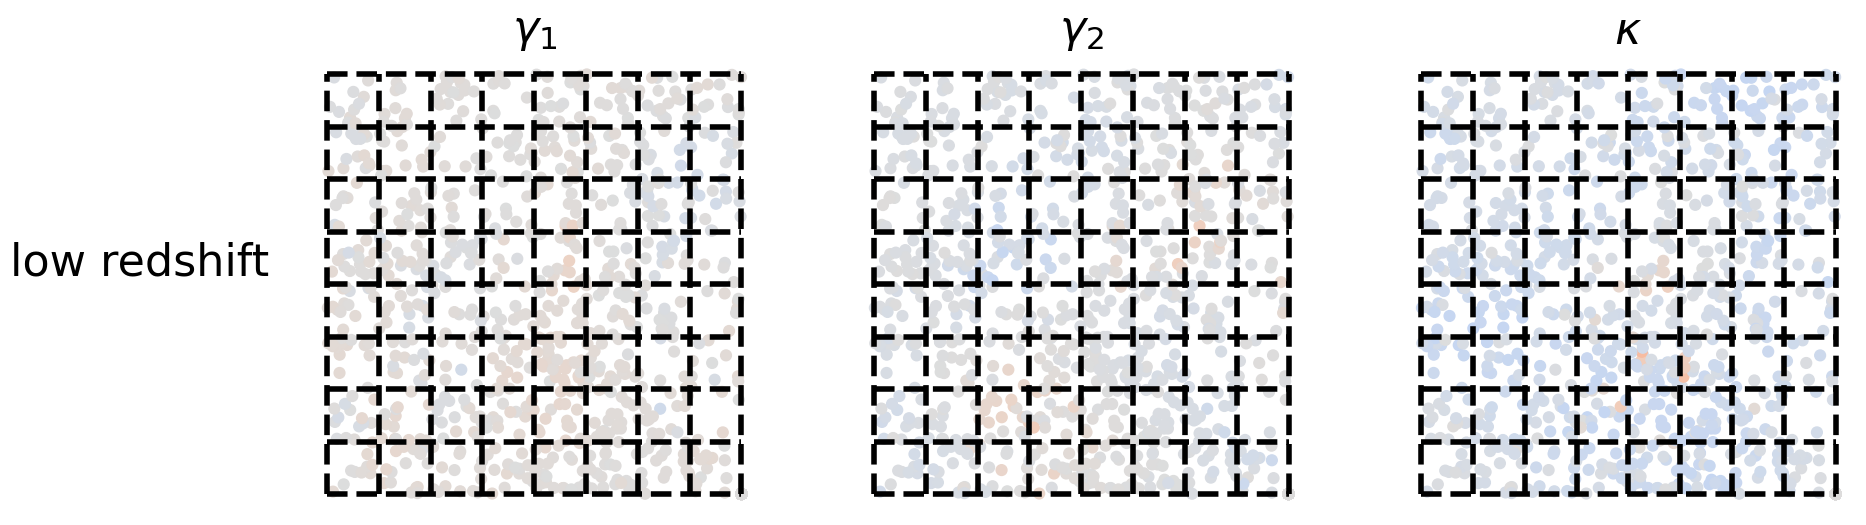

In [12]:
fig, ax = plt.subplots(1, 3, figsize=(20, 6))
alpha = 1
s = 60
fontsize = 32
cmap = 'coolwarm'
vmin = -0.06
vmax = 0.06

_ = ax[0].scatter(2048 - galaxy_plocs[:,1,0], galaxy_plocs[:,0,0], c=galaxy_shear1[:,0], vmin=vmin, vmax=vmax, alpha=alpha, s=s, cmap=cmap)
_ = ax[0].vlines(x=[256 * c for c in range(2048//256 + 1)], ymin=0, ymax=2048, color='black', linestyle='dashed', linewidth=4)
_ = ax[0].hlines(y=[256 * c for c in range(2048//256 + 1)], xmin=0, xmax=2048, color='black', linestyle='dashed', linewidth=4)
_ = ax[0].set_title(r'$\gamma_1$', fontsize=fontsize)
_ = ax[0].set_ylabel('low redshift', fontsize=fontsize, labelpad = 120, rotation = 0)
_ = ax[0].set_xticks([])
_ = ax[0].set_yticks([])

_ = ax[1].scatter(2048 - galaxy_plocs[:,1,0], galaxy_plocs[:,0,0], c=galaxy_shear2[:,0], vmin=vmin, vmax=vmax, alpha=alpha, s=s, cmap=cmap)
_ = ax[1].vlines(x=[256 * c for c in range(2048//256 + 1)], ymin=0, ymax=2048, color='black', linestyle='dashed', linewidth=4)
_ = ax[1].hlines(y=[256 * c for c in range(2048//256 + 1)], xmin=0, xmax=2048, color='black', linestyle='dashed', linewidth=4)
_ = ax[1].set_title(r'$\gamma_2$', fontsize=fontsize)
_ = ax[1].set_xticks([])
_ = ax[1].set_yticks([])

_ = ax[2].scatter(2048 - galaxy_plocs[:,1,0], galaxy_plocs[:,0,0], c=galaxy_convergence[:,0], vmin=vmin, vmax=vmax, alpha=alpha, s=s, cmap=cmap)
_ = ax[2].vlines(x=[256 * c for c in range(2048//256 + 1)], ymin=0, ymax=2048, color='black', linestyle='dashed', linewidth=4)
_ = ax[2].hlines(y=[256 * c for c in range(2048//256 + 1)], xmin=0, xmax=2048, color='black', linestyle='dashed', linewidth=4)
_ = ax[2].set_title(r'$\kappa$', fontsize=fontsize)
_ = ax[2].set_xticks([])
_ = ax[2].set_yticks([])

for a in ax.flat:
    for spine in a.spines.values():
        spine.set_visible(False)

fig.savefig("figures/dc2maps_pergalaxy_bin0.png", dpi = 300, transparent = True, bbox_inches = 'tight', pad_inches = 0)

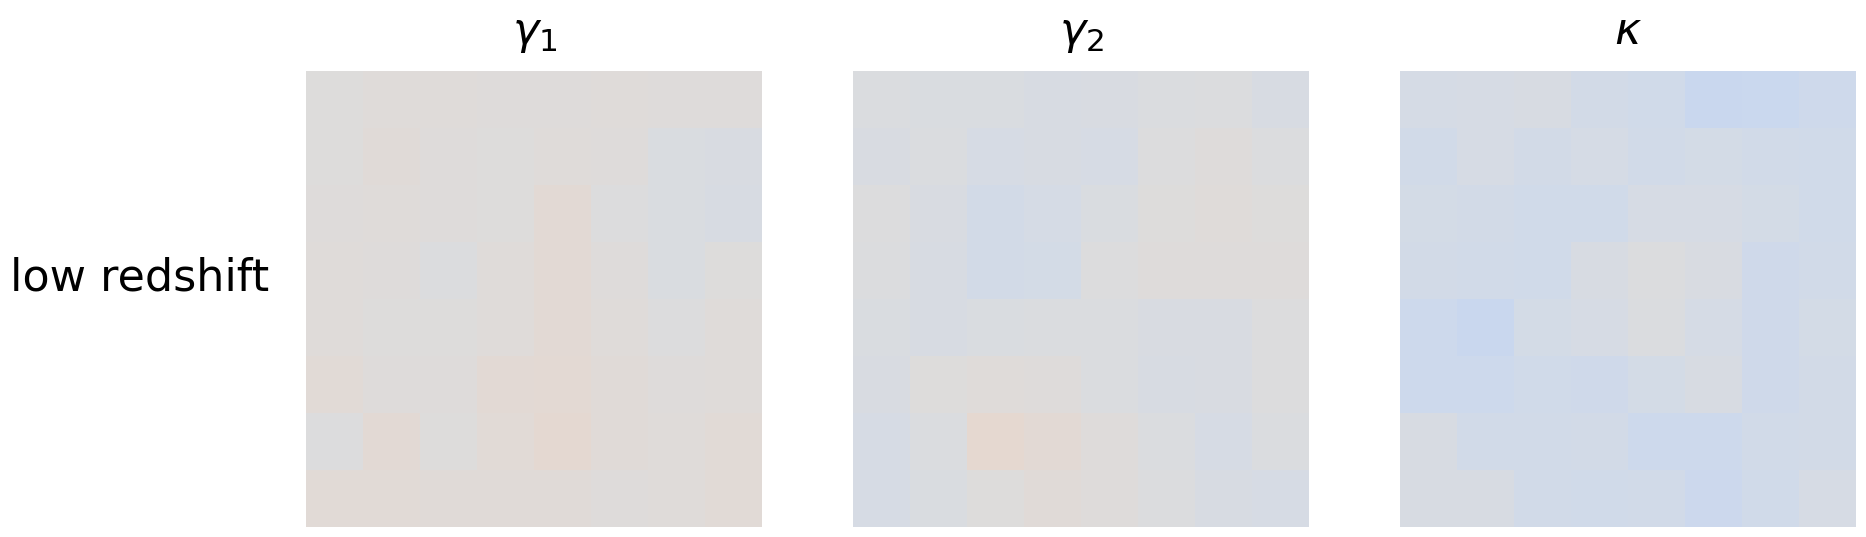

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(20, 6))

_ = ax[0].imshow(shear1[...,0], cmap=cmap, vmin=vmin, vmax=vmax)
_ = ax[0].set_title(r'$\gamma_1$', fontsize=fontsize, pad = 20)
_ = ax[0].set_ylabel('low redshift', fontsize=fontsize, labelpad = 120, rotation = 0)
_ = ax[0].set_xticks([])
_ = ax[0].set_yticks([])

_ = ax[1].imshow(shear2[...,0], cmap=cmap, vmin=vmin, vmax=vmax)
_ = ax[1].set_title(r'$\gamma_2$', fontsize=fontsize, pad = 20)
_ = ax[1].set_xticks([])
_ = ax[1].set_yticks([])

_ = ax[2].imshow(convergence[...,0], cmap=cmap, vmin=vmin, vmax=vmax)
_ = ax[2].set_title(r'$\kappa$', fontsize=fontsize, pad = 20)
_ = ax[2].set_xticks([])
_ = ax[2].set_yticks([])

for a in ax.flat:
    for spine in a.spines.values():
        spine.set_visible(False)

fig.savefig("figures/dc2maps_bin0.png", dpi = 300, transparent = True, bbox_inches = 'tight', pad_inches = 0)

Redshift bin 1:

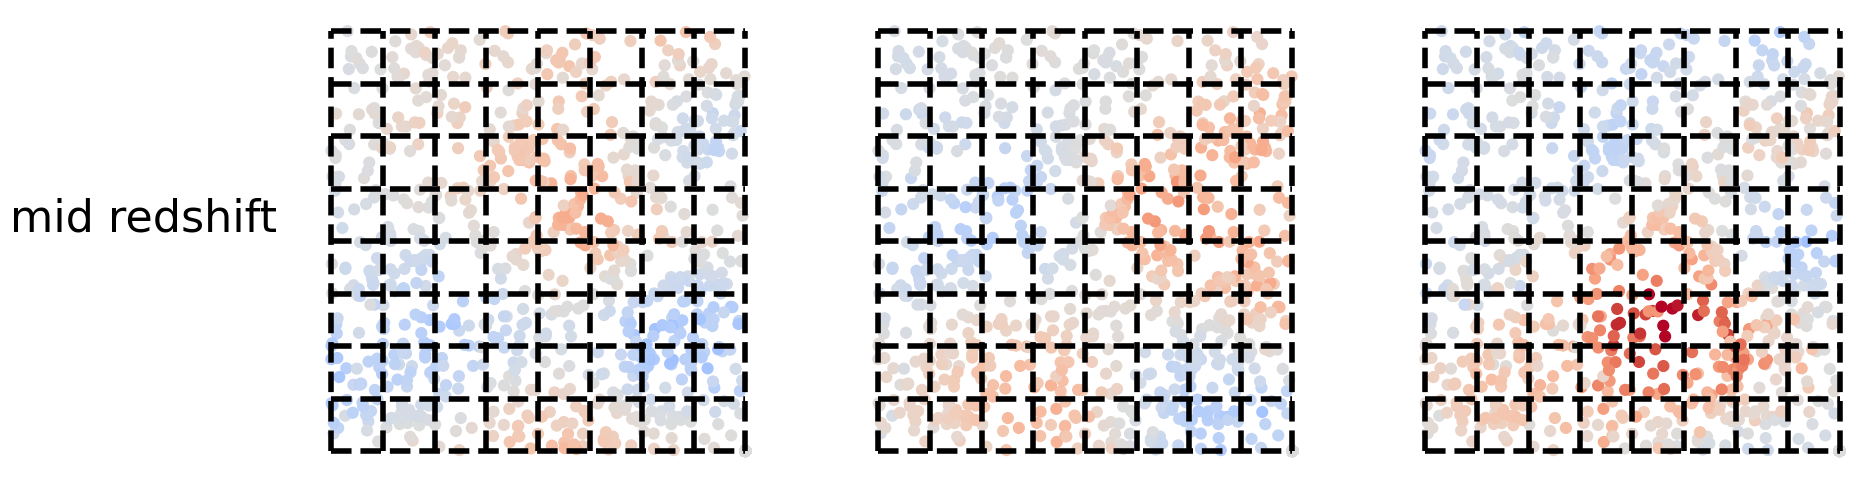

In [14]:
fig, ax = plt.subplots(1, 3, figsize=(20, 6))

_ = ax[0].scatter(2048 - galaxy_plocs[:,1,1], galaxy_plocs[:,0,1], c=galaxy_shear1[:,1], vmin=vmin, vmax=vmax, alpha=alpha, s=s, cmap=cmap)
_ = ax[0].vlines(x=[256 * c for c in range(2048//256 + 1)], ymin=0, ymax=2048, color='black', linestyle='dashed', linewidth=4)
_ = ax[0].hlines(y=[256 * c for c in range(2048//256 + 1)], xmin=0, xmax=2048, color='black', linestyle='dashed', linewidth=4)
_ = ax[0].set_ylabel('mid redshift', fontsize=fontsize, labelpad = 120, rotation = 0)
_ = ax[0].set_xticks([])
_ = ax[0].set_yticks([])

_ = ax[1].scatter(2048 - galaxy_plocs[:,1,1], galaxy_plocs[:,0,1], c=galaxy_shear2[:,1], vmin=vmin, vmax=vmax, alpha=alpha, s=s, cmap=cmap)
_ = ax[1].vlines(x=[256 * c for c in range(2048//256 + 1)], ymin=0, ymax=2048, color='black', linestyle='dashed', linewidth=4)
_ = ax[1].hlines(y=[256 * c for c in range(2048//256 + 1)], xmin=0, xmax=2048, color='black', linestyle='dashed', linewidth=4)
_ = ax[1].set_xticks([])
_ = ax[1].set_yticks([])

_ = ax[2].scatter(2048 - galaxy_plocs[:,1,1], galaxy_plocs[:,0,1], c=galaxy_convergence[:,1], vmin=vmin, vmax=vmax, alpha=alpha, s=s, cmap=cmap)
_ = ax[2].vlines(x=[256 * c for c in range(2048//256 + 1)], ymin=0, ymax=2048, color='black', linestyle='dashed', linewidth=4)
_ = ax[2].hlines(y=[256 * c for c in range(2048//256 + 1)], xmin=0, xmax=2048, color='black', linestyle='dashed', linewidth=4)
_ = ax[2].set_xticks([])
_ = ax[2].set_yticks([])

for a in ax.flat:
    for spine in a.spines.values():
        spine.set_visible(False)

fig.savefig("figures/dc2maps_pergalaxy_bin1.png", dpi = 300, transparent = True, bbox_inches = 'tight', pad_inches = 0)

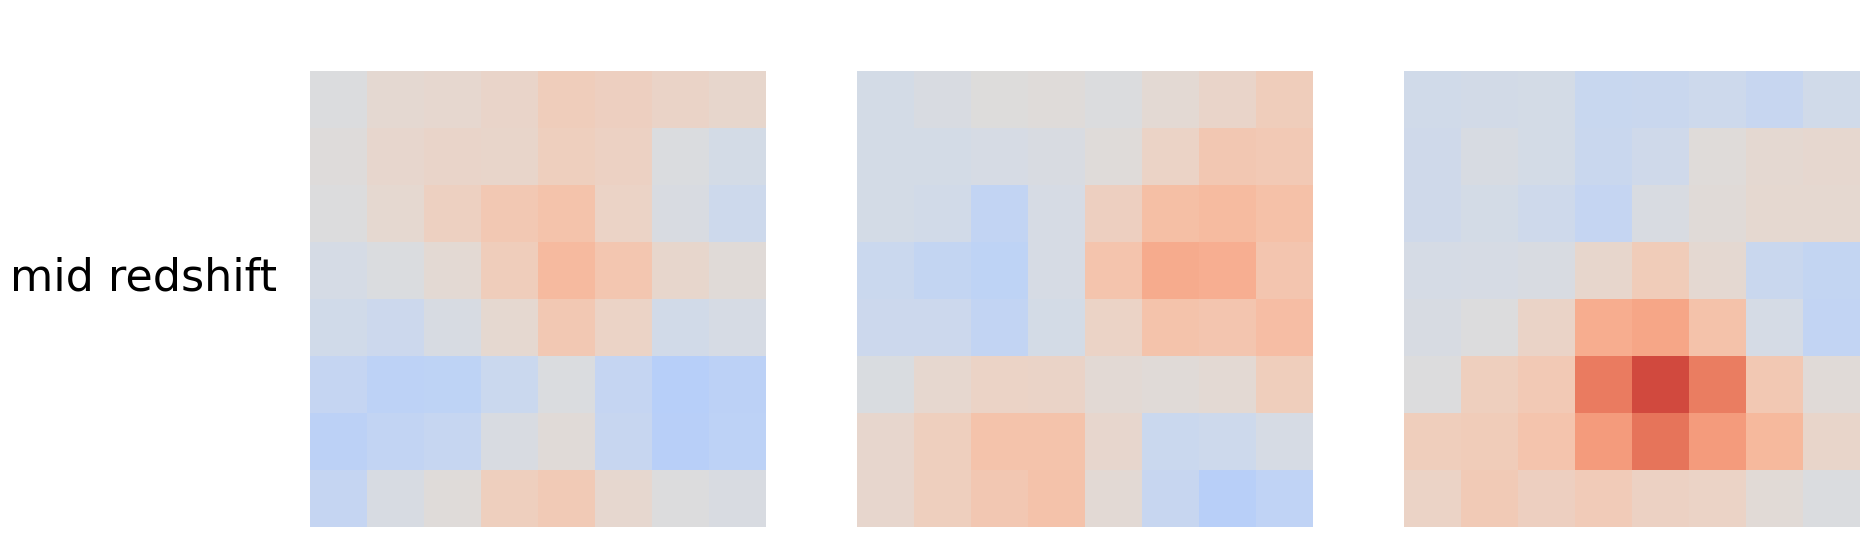

In [15]:
fig, ax = plt.subplots(1, 3, figsize=(20, 6))

_ = ax[0].imshow(shear1[...,1], cmap=cmap, vmin=vmin, vmax=vmax)
_ = ax[0].set_title(r'$\gamma_1$', fontsize=fontsize, pad = 20, color='white')
_ = ax[0].set_ylabel('mid redshift', fontsize=fontsize, labelpad = 120, rotation = 0)
_ = ax[0].set_xticks([])
_ = ax[0].set_yticks([])

_ = ax[1].imshow(shear2[...,1], cmap=cmap, vmin=vmin, vmax=vmax)
_ = ax[0].set_title(r'$\gamma_2$', fontsize=fontsize, pad = 20, color='white')
_ = ax[1].set_xticks([])
_ = ax[1].set_yticks([])

_ = ax[2].imshow(convergence[...,1], cmap=cmap, vmin=vmin, vmax=vmax)
_ = ax[2].set_title(r'$\kappa$', fontsize=fontsize, pad = 20, color='white')
_ = ax[2].set_xticks([])
_ = ax[2].set_yticks([])

for a in ax.flat:
    for spine in a.spines.values():
        spine.set_visible(False)

fig.savefig("figures/dc2maps_bin1.png", dpi = 300, transparent = True, bbox_inches = 'tight', pad_inches = 0)

Redshift bin 2:

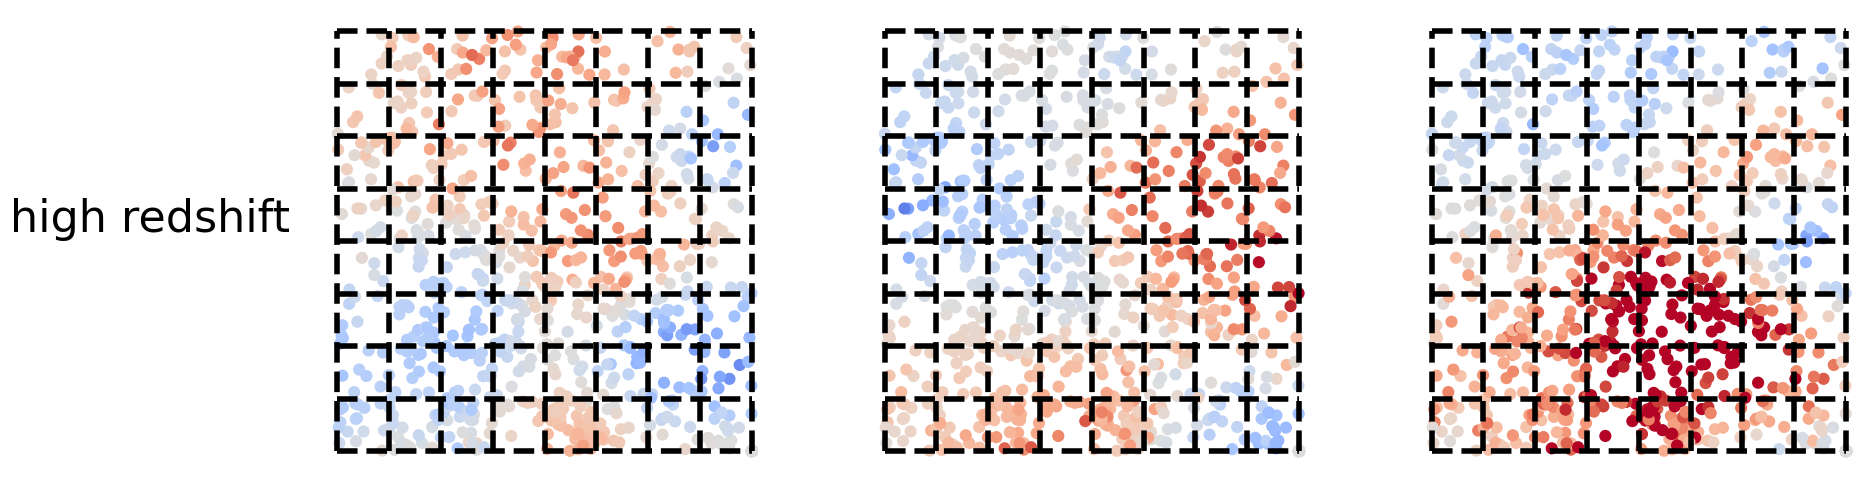

In [16]:
fig, ax = plt.subplots(1, 3, figsize=(20, 6))

_ = ax[0].scatter(2048 - galaxy_plocs[:,1,2], galaxy_plocs[:,0,2], c=galaxy_shear1[:,2], vmin=vmin, vmax=vmax, alpha=alpha, s=s, cmap=cmap)
_ = ax[0].vlines(x=[256 * c for c in range(2048//256 + 1)], ymin=0, ymax=2048, color='black', linestyle='dashed', linewidth=4)
_ = ax[0].hlines(y=[256 * c for c in range(2048//256 + 1)], xmin=0, xmax=2048, color='black', linestyle='dashed', linewidth=4)
_ = ax[0].set_ylabel('high redshift', fontsize=fontsize, labelpad = 120, rotation = 0)
_ = ax[0].set_xticks([])
_ = ax[0].set_yticks([])

_ = ax[1].scatter(2048 - galaxy_plocs[:,1,2], galaxy_plocs[:,0,2], c=galaxy_shear2[:,2], vmin=vmin, vmax=vmax, alpha=alpha, s=s, cmap=cmap)
_ = ax[1].vlines(x=[256 * c for c in range(2048//256 + 1)], ymin=0, ymax=2048, color='black', linestyle='dashed', linewidth=4)
_ = ax[1].hlines(y=[256 * c for c in range(2048//256 + 1)], xmin=0, xmax=2048, color='black', linestyle='dashed', linewidth=4)
_ = ax[1].set_xticks([])
_ = ax[1].set_yticks([])

_ = ax[2].scatter(2048 - galaxy_plocs[:,1,2], galaxy_plocs[:,0,2], c=galaxy_convergence[:,2], vmin=vmin, vmax=vmax, alpha=alpha, s=s, cmap=cmap)
_ = ax[2].vlines(x=[256 * c for c in range(2048//256 + 1)], ymin=0, ymax=2048, color='black', linestyle='dashed', linewidth=4)
_ = ax[2].hlines(y=[256 * c for c in range(2048//256 + 1)], xmin=0, xmax=2048, color='black', linestyle='dashed', linewidth=4)
_ = ax[2].set_xticks([])
_ = ax[2].set_yticks([])

for a in ax.flat:
    for spine in a.spines.values():
        spine.set_visible(False)

fig.savefig("figures/dc2maps_pergalaxy_bin2.png", dpi = 300, transparent = True, bbox_inches = 'tight', pad_inches = 0)

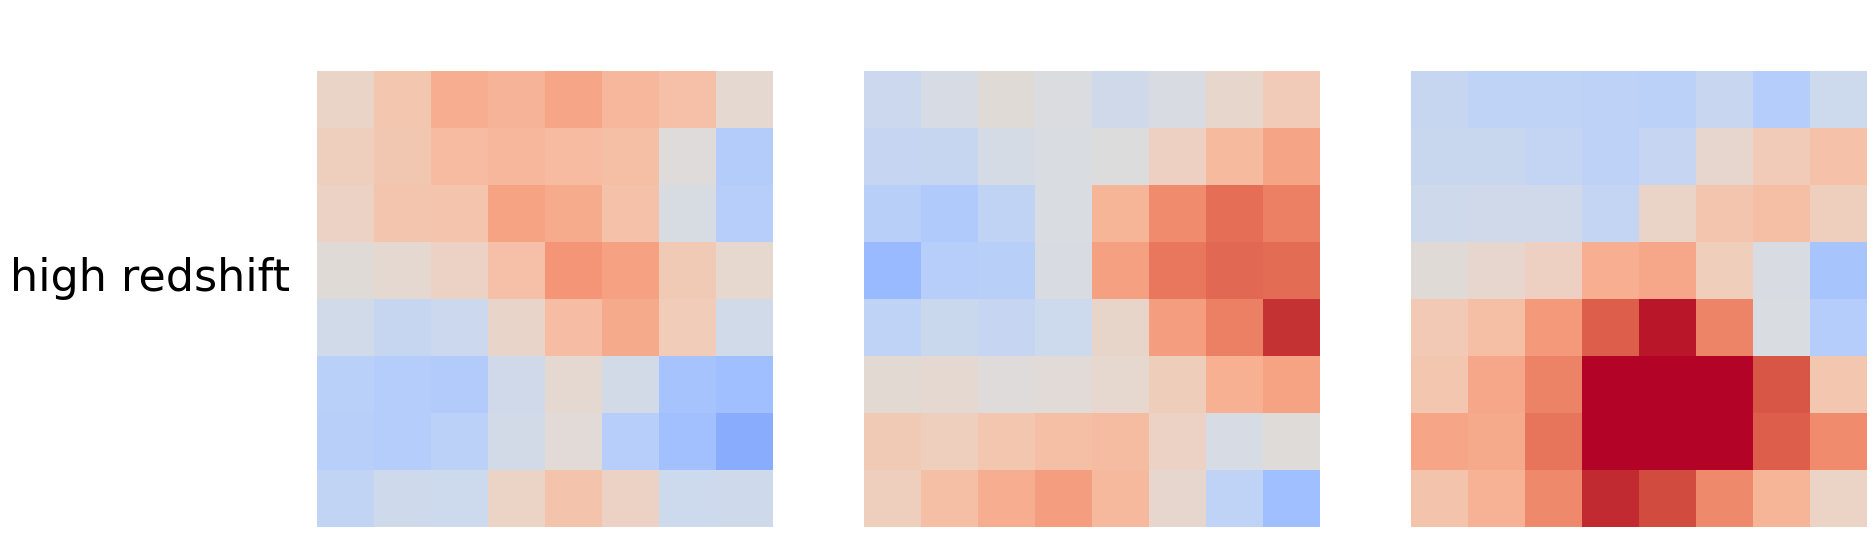

In [17]:
fig, ax = plt.subplots(1, 3, figsize=(20, 6))

_ = ax[0].imshow(shear1[...,2], cmap=cmap, vmin=vmin, vmax=vmax)
_ = ax[0].set_title(r'$\gamma_1$', fontsize=fontsize, pad = 20, color='white')
_ = ax[0].set_ylabel('high redshift', fontsize=fontsize, labelpad = 120, rotation = 0)
_ = ax[0].set_xticks([])
_ = ax[0].set_yticks([])

_ = ax[1].imshow(shear2[...,2], cmap=cmap, vmin=vmin, vmax=vmax)
_ = ax[0].set_title(r'$\gamma_2$', fontsize=fontsize, pad = 20, color='white')
_ = ax[1].set_xticks([])
_ = ax[1].set_yticks([])

_ = ax[2].imshow(convergence[...,2], cmap=cmap, vmin=vmin, vmax=vmax)
_ = ax[0].set_title(r'$\kappa$', fontsize=fontsize, pad = 20, color='white')
_ = ax[2].set_xticks([])
_ = ax[2].set_yticks([])

for a in ax.flat:
    for spine in a.spines.values():
        spine.set_visible(False)

fig.savefig("figures/dc2maps_bin2.png", dpi = 300, transparent = True, bbox_inches = 'tight', pad_inches = 0)